# Predicting CO₂ Levels
Mark van der Wilk, Spring 2021, Probabilistic Inference, Imperial College London

We saw in the lecture how the marginal likelihood could be used to select good
parameters for the kernel. Here, we will use hyperparameter selection, together
a manual search guided by the marginal likelihood to find a good kernel to
predict CO₂ levels in the atmosphere.

We shall investigate:
- Local optima in the log marginal likelihood (LML) surface.
- Composing kernels to get good fit and extrapolation.
- Using marginal likelihood for model selection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from gpflow.kernels import *
from gpflow.utilities import print_summary, set_trainable, positive
from tools import datasets
from tools import plotting
from tools.misc import sample_prior

gpflow.config.set_default_positive_minimum(1e-6)

save_figures_location = "/Users/markvdw/Documents/teaching/probabilistic-inference/2021/slides/figures/model_selection/"
savefig = lambda fig, fn: fig.savefig(f"{save_figures_location}{fn}") if savefig is not None else None

raw_d = datasets.load_data("03-mauna.mat")
raw_d = raw_d.normalise(raw_d.X.min(), 1, raw_d.Y.min(), 1)  # Start at (0,0)

d = raw_d.subset(np.s_[:int(len(raw_d.X) * 0.7)])
dt = raw_d.subset(np.s_[int(len(raw_d.X) * 0.7):])

# pX = np.linspace(1990, 2005, 500)[:, None]
pX = np.linspace(0, 50, 1000)[:, None]
# pXs = np.linspace(1960, 1990, 400)[:, None]
pXs = np.linspace(0, 30, 400)[:, None]

def make_plot(m, kernel_name, plot_samples=True):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4))
    samples = sample_prior(m.kernel, pXs)
    ax1.plot(pXs, samples, color='C0', alpha=0.3)
    ax1.plot(d.X, d.Y, 'x', color='C1')
    ax1.set_xlim(pXs.min(), pXs.max())

    plotting.plot_1d_model(m, plot_samples=plot_samples, plot_mean=True, plot_var='y', ax=ax2, pX=pX)
    ax2.set_xlim(30, 50)
    ax2.plot(dt.X, dt.Y, 'x', color='C2')
    ax2.set_ylim(30, 80)

    fig.suptitle(f"{kernel_name} kernel - LML: {m.log_marginal_likelihood().numpy():.2f}")
    return fig, (ax1, ax2)

opt = gpflow.optimizers.Scipy()

# We need to constrain the parameters to be positive with a small lower bound,
# although a bit larger than the GPflow default, to ensure no Cholesky errors.
# Adding a diagonal term increases all the eigenvalues of the kernel matrix,
# which makes the matrix better conditioned, which prevenst CholeskyErrors.
positive_transform = positive(lower=1e-4)

models = []
model_names = []

## Data
Let's look at the data first. The data consists of measurements of the CO₂
levels in the atmosphere at multiple times per year. Unfortunately, the place
where I found this dataset has normalised the levels, so the units are not
directly something interpretable (like ppm). However, the trend is completely
the same.

Let's try to predict into the future.

Text(0, 0.5, 'Normalised CO₂')

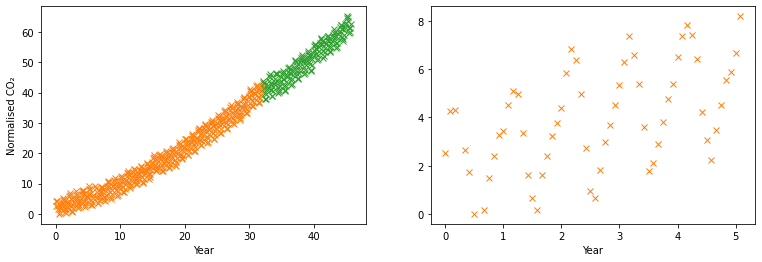

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4))
ax1.plot(d.X, d.Y, 'x', color='C1')
ax1.plot(dt.X, dt.Y, 'x', color='C2')
ax2.plot(d.X[:60], d.Y[:60], 'x', color='C1')
ax1.set_xlabel("Year"); ax2.set_xlabel("Year")
ax1.set_ylabel("Normalised CO₂")

## Local Optima
Let's first just try to use a basic Squared Exponential kernel. We will see
that we converge to a different local optimum depending on where we initialise
the hyperparameters.

### Short lengthscale initialisation
We start by initialising the lengthscale near the scale of the shortest
"wiggle" in the data, which is on the order of 0.5 years.

We see that:
- The uncertainty grows nicely when we get away from the data... but not even
  enough to not be wrong.
- The extrapolation is awful, the mean goes back to zero! Why? Because that's
  what the prior expects! The prior expects all functions to go back to wiggle
  around 0, without long-term trend.

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 254.061     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   0.303582  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   0.0513548 │
╘═════════════════════════╧═══════════╧══════════════════╧══════

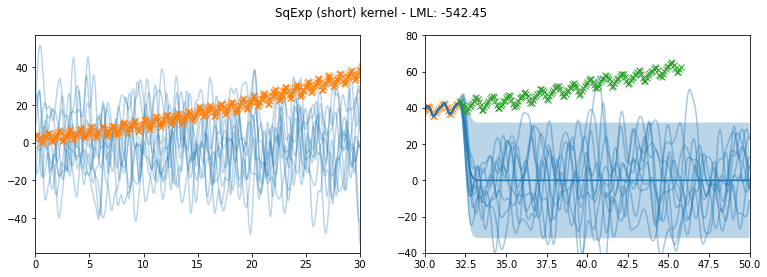

In [3]:
m = gpflow.models.GPR((d.X, d.Y), SquaredExponential())
m.likelihood.variance.assign(0.1 ** 2.0)
m.kernel.lengthscales.assign(0.8)
opt.minimize(m.training_loss, variables=m.trainable_variables)
fig, (ax1, ax2) = make_plot(m, "SqExp (short)")
ax2.set_ylim(-40, 80)
print_summary(m)
models.append(m)
model_names.append("SqExp (short)")

### Long lengthscale initialisation
Let's try to capture the long-term trend instead. Let's try to initialise the
lengthscale a bit longer. Does it fall into a different local optimum? We see
that by intialising at a lengthscale of 1 instead of 0.8, we fall into a very
different local optimum!

Small changes can make a big difference to where you get taken by the
optimiser. As soon as you make the lengthscsale larger than 1 year, the
initialised GP cannot fit the seasonal trends, which occur within a year. So
the gradients only "see" that you can improve the marginal likelihood by
correlating points that are far away.

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 3988.61    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   53.8723  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    4.16319 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════

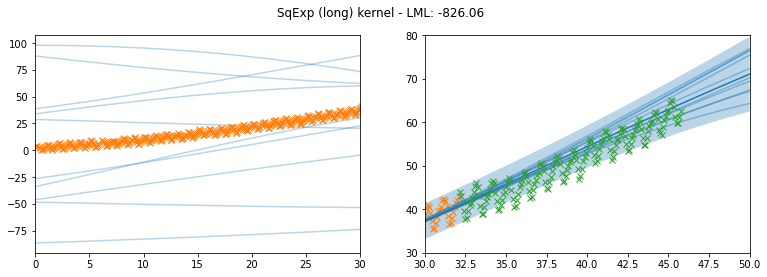

In [4]:
m = gpflow.models.GPR((d.X, d.Y), SquaredExponential())
m.likelihood.variance.assign(0.1 ** 2.0)
m.kernel.lengthscales.assign(1)
opt.minimize(m.training_loss, variables=m.trainable_variables)
fig, (ax1, ax2) = make_plot(m, "SqExp (long)")
print_summary(m)
models.append(m)
model_names.append("SqExp (long)")

We see that the model captures the long-term trend a bit better. We get a
better extrapolation, although it's a bit overconfident. Perhaps we can get the
best of both worlds if we had a sum of the two kernels?

## Best of Both Worlds: Long and Short Lengthscale
We saw that there were two local optima for the hyperparameters of the SqExp
kernel, which both captured a relevant aspect of the data, but which couldn't
really extrapolate in the right way. A sum of these two behaviours could capture
both behaviours! Let's take the sum of the two kernels.

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    5.35331   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    0.192097  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus + Shift │         │ True        │ () 

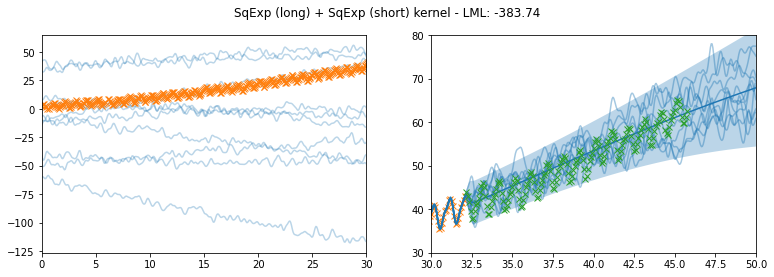

In [5]:
sqexp_short = SquaredExponential()
sqexp_short.lengthscales.assign(0.5)
sqexp_long = SquaredExponential()
kernel = sqexp_short + sqexp_long
m = gpflow.models.GPR((d.X, d.Y), kernel)
m.likelihood.variance.assign(0.1 ** 2.0)
opt.minimize(m.training_loss, variables=m.trainable_variables)
make_plot(m, "SqExp (long) + SqExp (short)")
print_summary(m)
models.append(m)
model_names.append("SqExp (long) + SqExp (short)")


We also see that the marginal likelihood for this model is much higher than for
the earlier ones!

## Capturing Periodicity
While the previous model captures the overall predictive trend quite nicely, as
well as the short-term variation *on the training set*, it does not predict the
seasonal periodic variation well beyond the training set. If we choose a prior
that has near-periodic functions in them, then we will extrapolate well.

It's worth thinking about this for a moment. The current prior contains
functions which are only correlated locally. Over larger distances, the
function values become independent. This can be seen by the covariance going to
zero. Sure, for the long-lengthscale component it takes very long for the
covariance to go to zero, so this captures the long-term trend. But we want
something that can capture the short term trend *and* know that it should
highly correlate the function values for future years! This is what a periodic
kernel does. By having near-periodic functions in the prior, we actually
*constrain* the predictions we can make to have this periodic structure. If
this is the correct structure, we generalise better!

We saw earlier that multiplying a SqExp and Periodic kernel gives us quasi-
periodic behaviour: The period looks similar for nearby periods, but varies
over longer distances. This is what we need here, because we see that not every
period is exactly the same.

Let's replace the short lengthscale SqExp with a quasi-periodic component.


╒═══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                 │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 39.9128    │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales             │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 60.3623    │
├───────────────────────────────────────────────────────────┼───────────┼──────────────────┼────────

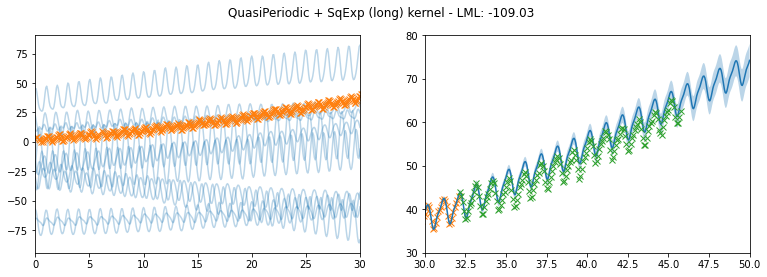

In [6]:
quasi_periodic = SquaredExponential() * Periodic(SquaredExponential())
sqexp_long = SquaredExponential(lengthscales=1)
kernel = quasi_periodic + sqexp_long
m = gpflow.models.GPR((d.X, d.Y), kernel)
m.likelihood.variance = gpflow.Parameter(0.1 ** 2.0, transform=positive_transform)
opt.minimize(m.training_loss, variables=m.trainable_variables)
make_plot(m, "QuasiPeriodic + SqExp (long)", plot_samples=False)
print_summary(m)
models.append(m)
model_names.append("QuasiPeriodic + SqExp (long)")

Wow, this looks pretty cool, but the extrapolation does look overconfident
again. What could cause this? By looking at the hyperparameters that the
optimiser finds, we see that we have one SqExp which captures the long-term
trend. If we look at the prior samples, we see that the long-term trends that
are allowed in the prior are almost linear. This is too restrictive for our
data which seems to have slight bumps and bends in them.

Now that we replace the shorter lengthscale SqExp with the quasi-periodic
kernel, we do not have a way to capture these shorter term trends anymore.
Let's add this capability back in.

## Trend, Periodicity and Deviations
We add another SqExp kernel to capture medium-term trends this time.

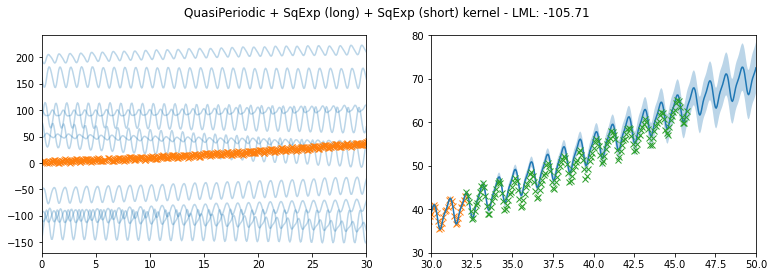

In [7]:
sqexp_short = SquaredExponential()
sqexp_long = SquaredExponential(lengthscales=10)
quasi_periodic = SquaredExponential() * Periodic(SquaredExponential(lengthscales=0.8))
kernel = quasi_periodic + sqexp_long + sqexp_short

m = gpflow.models.GPR((d.X, d.Y), kernel)
m.likelihood.variance.assign(0.1 ** 2.0)

opt.minimize(m.training_loss, variables=m.trainable_variables)

fig, (ax1, ax2) = make_plot(m, "QuasiPeriodic + SqExp (long) + SqExp (short)", plot_samples=False)
# print_summary(m)
# ax2.set_xlim(31, 37)
# ax2.set_ylim(35, 50)
models.append(m)
model_names.append("QuasiPeriodic + SqExp (long) + SqExp (short)")

We see that we're a bit overconfident in the predictions. Changing the SqExp to a RationalQuadratic can
help with this, as this kernel effectively allows deviations on multiple lengthscales (see §4.2 in
Rasmussen & Williams). We still end up being a bit overconfident...

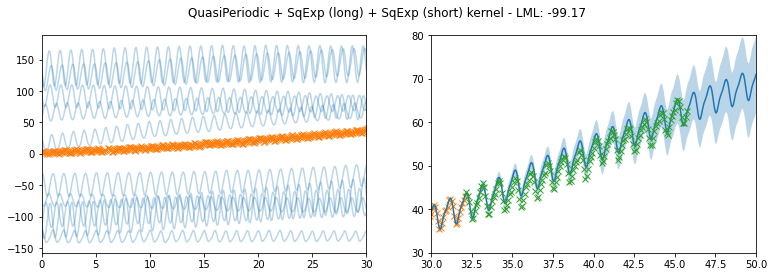

In [8]:
sqexp_short = RationalQuadratic()
sqexp_long = SquaredExponential(lengthscales=10)
quasi_periodic = SquaredExponential() * Periodic(SquaredExponential(lengthscales=0.8))
kernel = quasi_periodic + sqexp_long + sqexp_short

m = gpflow.models.GPR((d.X, d.Y), kernel)
m.likelihood.variance.assign(0.1 ** 2.0)
opt.minimize(m.training_loss, variables=m.trainable_variables)

fig, (ax1, ax2) = make_plot(m, "QuasiPeriodic + SqExp (long) + SqExp (short)", plot_samples=False)

models.append(m)
model_names.append("QuasiPeriodic + SqExp (long) + SqExp (short)")

## Testing metrics
Let's see how our models work according to different testing metrics:
- Root Mean Squared Error (RMSE). Doesn't capture uncertainty.
- Negative Log Predictive Density (NLPD). Captures uncertainty.

We will measure these metrics for the full test set, as well as the last 10
points to estimate long-term prediction.

In [9]:
from scipy.stats import multivariate_normal
print(f"{'':46s}rmse\tnlpd\tlml")
rmses = []
nlpds = []
lmls = []
for mn, m in zip(model_names, models):
    last = 50
    rmse = np.mean((m.predict_y(dt.X)[0] - dt.Y) ** 2.0) ** 0.5
    nlpd = -np.mean(m.predict_log_density((dt.X[:, :], dt.Y[:, :])))
    lml = m.log_marginal_likelihood().numpy()
    rmses.append(rmse)
    nlpds.append(nlpd)
    lmls.append(lml)
    print(f"{mn:46}{rmse:4.2f}\t{nlpd:3.2f}\t{lml:3.2f}")

    # We could consider the joint predictive density... But this is unusual,
    # and I don't want to complicate things...
    # nlpd_joint = -multivariate_normal.logpdf(dt.Y.flatten(), pm.flatten(), pv[0, :, :])
    # pm, pv = [r.numpy() for r in m.predict_f(dt.X, full_cov=True)]
    # pv = pv + np.eye(len(dt.X)) * m.likelihood.variance.numpy()
    # print(f"{mn:46}{nlpd_all:4.2f}\t{nlpd_last:3.2f}\t{nlpd_joint:3.2f}\t{rmse_all:3.2f}   \t{rmse_last:3.2f}")

                                              rmse	nlpd	lml
SqExp (short)                                 50.64	8.71	-542.45
SqExp (long)                                  2.90	2.55	-826.06
SqExp (long) + SqExp (short)                  2.47	2.43	-383.74
QuasiPeriodic + SqExp (long)                  2.24	5.34	-109.03
QuasiPeriodic + SqExp (long) + SqExp (short)  1.86	3.58	-105.71
QuasiPeriodic + SqExp (long) + SqExp (short)  1.52	2.20	-99.17


# Discussion & Conclusion
So we used maximum log marginal likelihood (LML) to find the kernel and likelihood
hyperparameters. Generally this worked well. There wasn't really a single case
where it seemed like the wrong parameters were chosen (e.g. an overfitting
solution where the noise was fit instead of an aspect of the signal).

We also used the marginal likelihood to compare between different kernels. If
the marginal likelihood were an ideal way to do model selection, we would see
*perfect* correlation between the predictive performance *in all metrics*. We
saw that:
- Generally, the RMSE improved as the LML increased.
- Our best-performing model in all metrics had the highest LML.
- Overconfidence is penalised heavily in the NLPD metric. This broke the
  correlation between LML and NLPD in some cases.

So I would say that maximum log marginal likelihood:
- works very well for selecting a limited number of hyperparameters for a given
  kernel,
- works pretty well for searching through different kernels, definitely for
  RMSE.

Don't forget how hard the question is that we asked it! We asked the marginal
likelihood: based on how well the model did on the current data, how well do
you think the model will do on *future* data?

Looking only at the training loss totally couldn't do this. All models that had
a short-term SqExp in the kernel, had a mean that fit the training data almost
perfectly.

There is some debate in the statistics community about how good the marginal
likelihood *really* is for model selection. It is by no means perfect, and we
saw an example of that here! My take is that:
- For the selection of a small number of continuous model parameters, the
  marginal likelihood works incredibly well.
- For discrete model comparison, the practical solution of comparing
  *optimised* LML values works surprisingly well, but certainly does fail at
  times. But keep in mind that we're doing a crude approximation of what the
  rules of probability *really* tell us what to do! So it's not surprising
  that there are failure modes.
- Also, keep in mind the alternatives. We are finding how to generalise by
  maximising a criterion on the *training* set! The marginal likelihood
  certainly behaves much better than simply the training loss. The main
  alternative method for model selection is cross-validation.
- In practice, you should use both methods in a statistical analysis, like we
  did here! Cross-validation can be cumbersome, so being able to optimise
  continuous hyperparameters is convenient. for the discrete model comparison
  we used the marginal likelihood as a guide, and then verified our results
  with cross-validation.

So my advice is, when you have an estimate of the marginal likelihood: *use it
when it's convenient, but verify your results with cross-validation (or a
validation set).*

## Other things to keep in mind
### Effect of approximations
We should remember that we did some approximations! We use a point estimate of
the hyperparameters instead of doing Bayesian inference over them! Perhaps
doing proper Bayesian inference would make the predictions more cautious, which
would make the NLPD metric correlate better with the marginal likelihood. This
can be done with approximate inference methods, which we will look at later.

### Could we push the search further?
Yes. We could search further through kernels. Perhaps it would be a good idea
to replace the long-lengthscale SqExp kernel with a Linear/Quadratic/Polynomial
kernel to capture the long-term trend? In this case, a low-degree polynomial
does seem appropriate.

It's likely that you will find some more examples of hyperparameter settings
that have slightly worse generalisation performance, but higher marginal
likelihoods. But again, it's very rare to see a case where the LML does
something weird for continuous parameter selection!

### Test Metrics
There is a lot more to say about what the right test metric is *for this
problem*. My experience with machine learning in industrial settings is that
one of the most important choices is how you measure success. In academia there
is sometimes a tendency to focus on improving benchmark numbers which are based
on simple things like rmse, nlpp, or classification accuracy. But even when
using these metrics in a situation like this, we have many choices. Long term
vs short-term predictions are just one!

The best way to get good at this, is to do machine learning in practice, and
*really think* about what you're trying to achieve. One interesting paper
that, in my opinion (warning: availability bias), really thinks about the task
is [1]. Causal machine learning is another area which rethinks many metrics and
tries to think of more realistic scenarios to test in.

I think the ML fairness community is doing really great work in thinking about
this as well. Talk to the people who actually use your tools. Talk to social
scientists.

[1] https://arxiv.org/abs/1909.12434